# Goal: Make Images for Each Spider

The goal of this notebook is to make raster plots and ACF plots for each spider by
<ol>
<li>Make raster plots and ACF plots for each spider during the LD period and DD period separately</li>
<li>Make a .csv file to save the result of the rhythm of each spider after visual inspection</li>
</ol>

## Import Relevant Packages

In [1]:
#Import relevant packages
import pandas as pd
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import csv
from statsmodels.tsa.stattools import periodogram

## Import Relevant Functions

In [26]:
#The length of a day in mins
one_day=24*60

#Plot the raster plots and the ACF for a spider
#RasterData: a dataframe containing data for raster plot
#Spider: the specific spider to be plotted
#RollingData: a dataframe containing rolling average data for ACF
#FileName: the .png filename of each plot
#Return the raster and ACF plot of the spider 
def Plot_Raster_ACF(RasterData,Spider,RollingData,FileName):
    
    #Define the size of the figure
    plt.figure(figsize=(15,15))
    
    #Plotting the raster plot in the left panel
    #The number of days included in the RasterData
    number_of_days=int(len(RasterData)/one_day)
    
    #Loop through days and plot daily activity as a subplot 
    for i in range(0,number_of_days):
        
        #Separate the RasterData in the length of one day
        data=pd.DataFrame(RasterData.iloc[0+i*one_day:one_day+i*one_day])
        
        #Share the subplots in the left panel with the same x-axis 
        if i==0:
            ax1=plt.subplot(number_of_days,2,2*i+1)
            ax0=ax1
        else:
            ax1=plt.subplot(number_of_days,2,2*i+1,sharex=ax0)
        if i<number_of_days-1:
            plt.setp(ax1.get_xticklabels(), visible=False)
        
        #Plot the raster plot
        ax1.plot(data.Time,data[Spider])
        
        #Set the date as y-axis label
        ax1.set_ylabel(data.Date[1])
        
        #Indicate the dark portion of the day by gray shading
        light=True
        for t in data.index:
            if data.lights[t]==0:
                if light:
                    light=False
                    start=t
            else:
                if not light:
                    light=True
                    ax1.axvspan(data.Time[start],data.Time[t], alpha=0.3, color='gray')
        if not light:
            ax1.axvspan(data.Time[start],data.Time[t], alpha=0.3, color='gray')
        
    #The number of ticks in x-axis and the length between each point
    number_of_points=6
    len_between_points=24*60/number_of_points
    
    #Define the range of the x-axis and change the number of ticks on x-axis
    plt.xticks(range(0,int(one_day)+1,int(len_between_points)))
    plt.xlim(0,one_day)
     
    #Plotting the ACF Plot in the right panel
    #The total length of the lags, the number of lags, the number of ticks on the x-axis and the length between each tick
    hours=36
    lag=hours*60
    tick_count=6
    len_between_ticks=lag/tick_count
    
    #Plot the ACF
    ax2=plt.subplot(1,2,2)
    plot_acf(RollingData,lags=lag,ax=ax2)
    
    #Change the unit of the x-axis into hours
    x=range(0,int(lag)+1,int(len_between_ticks))
    ax2.set_xticks(x)
    labels=[]
    for i in range(0,hours+1,tick_count):
        labels.append(str(i))
    ax2.set_xticklabels(labels)
    
    #Adjust the layout of the plots to avoid overlapping 
    plt.tight_layout()
    
    #Save the figure as a .png document
    #plt.savefig(FileName)
    
    return plt.show()

## Read the cleaned data and change the index into proper form

In [3]:
#Read the cleaned .csv files and change the index into Date_Time
LD=pd.read_csv('LD.csv')
DD=pd.read_csv('DD.csv')
LD.index=pd.to_datetime(LD.Date+' '+LD.Time)
DD.index=pd.to_datetime(DD.Date+' '+DD.Time)
LD.head()

Unnamed: 0       Date     Time  lights  s1  s2  \
2017-09-22 00:00:00  2017-09-22 00:00:00  22-Sep-17  0:00:00       0  15   0   
2017-09-22 00:01:00  2017-09-22 00:01:00  22-Sep-17  0:01:00       0   0   0   
2017-09-22 00:02:00  2017-09-22 00:02:00  22-Sep-17  0:02:00       0   0   0   
2017-09-22 00:03:00  2017-09-22 00:03:00  22-Sep-17  0:03:00       0   2   0   
2017-09-22 00:04:00  2017-09-22 00:04:00  22-Sep-17  0:04:00       0   3   0   

                     s3  s4  s5  s6  ...  s15  s16  s17  s18  s19  s21  s22  \
2017-09-22 00:00:00   0   0   0   0  ...   19    0   22    0    0    0    0   
2017-09-22 00:01:00   0   0   0   0  ...    3    0   19    0    1    0    0   
2017-09-22 00:02:00   0   0   0   0  ...   13    0   13    0   19    0    0   
2017-09-22 00:03:00   0   0   0   0  ...    6    0   14    0    3    0    0   
2017-09-22 00:04:00   0   0   0   0  ...    4    0    9    0    8    0    0   

                     s25  s27  s30  
2017-09-22 00:00:00    0    0   43  
2017-09-22 00:01:00    0    0   50  
2017-09-22 00:02:00    0    0   55  
2017-09-22 00:03:00    0    0   52  
2017-09-22 00:04:00    0    0   57  

[5 rows x 26 columns]

## Calculate the rolling average of the spider activity

In [4]:
#Calculate the rolling average with 2.5 hour offset and save as dataframes
LD_Rolling=LD.rolling('2.5 H').mean()
DD_Rolling=DD.rolling('2.5 H').mean()

## Plot the Raster and ACF for each spider

In [29]:
#Get the "healthy" subjects left after the clean-up process from the Alive.csv file
df_alive=pd.read_csv('Alive.csv')
df_alive.set_index('ID',inplace=True)

#Save the alive spiders' id name into a list
spider=df_alive[df_alive['Alive']==1].index.tolist()

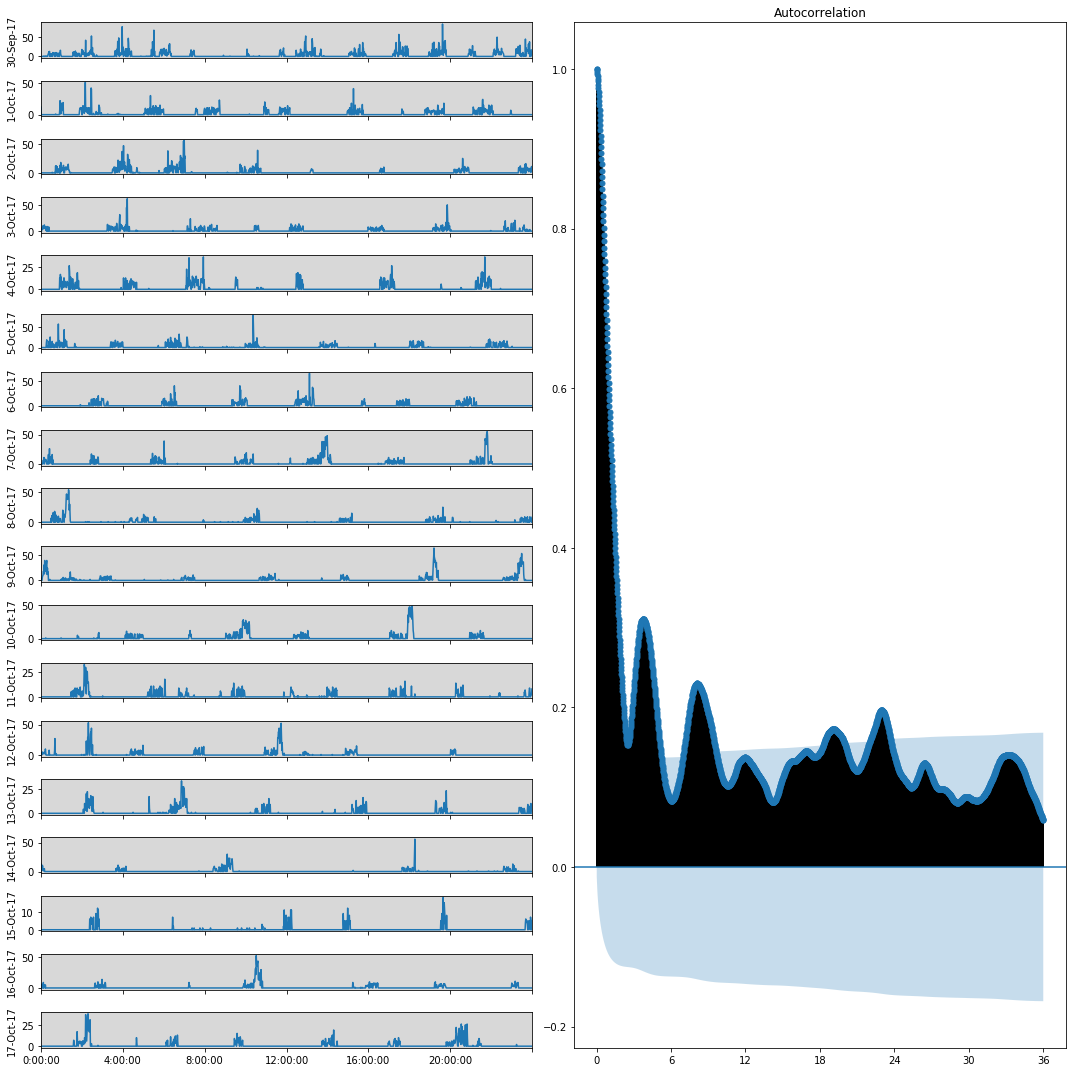

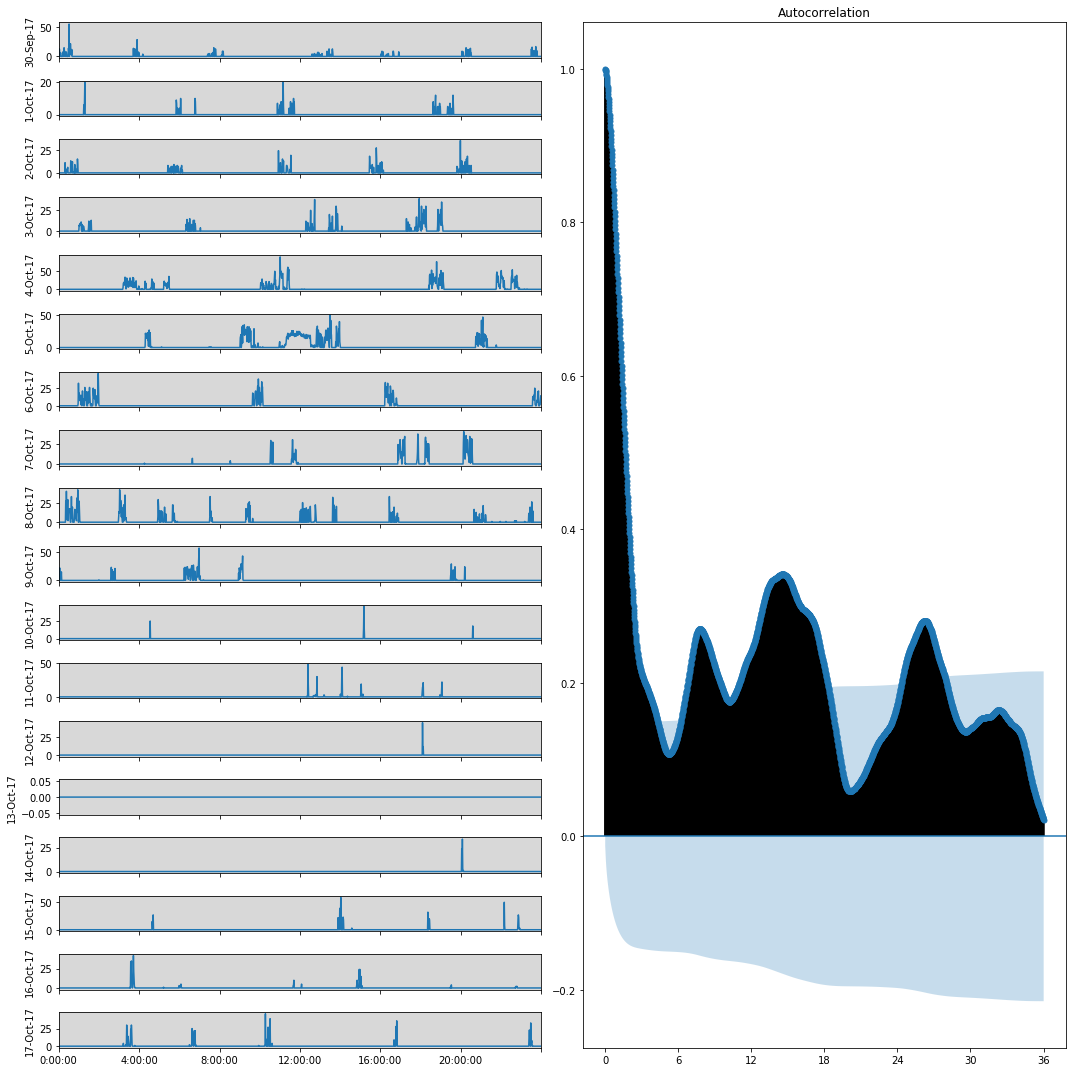

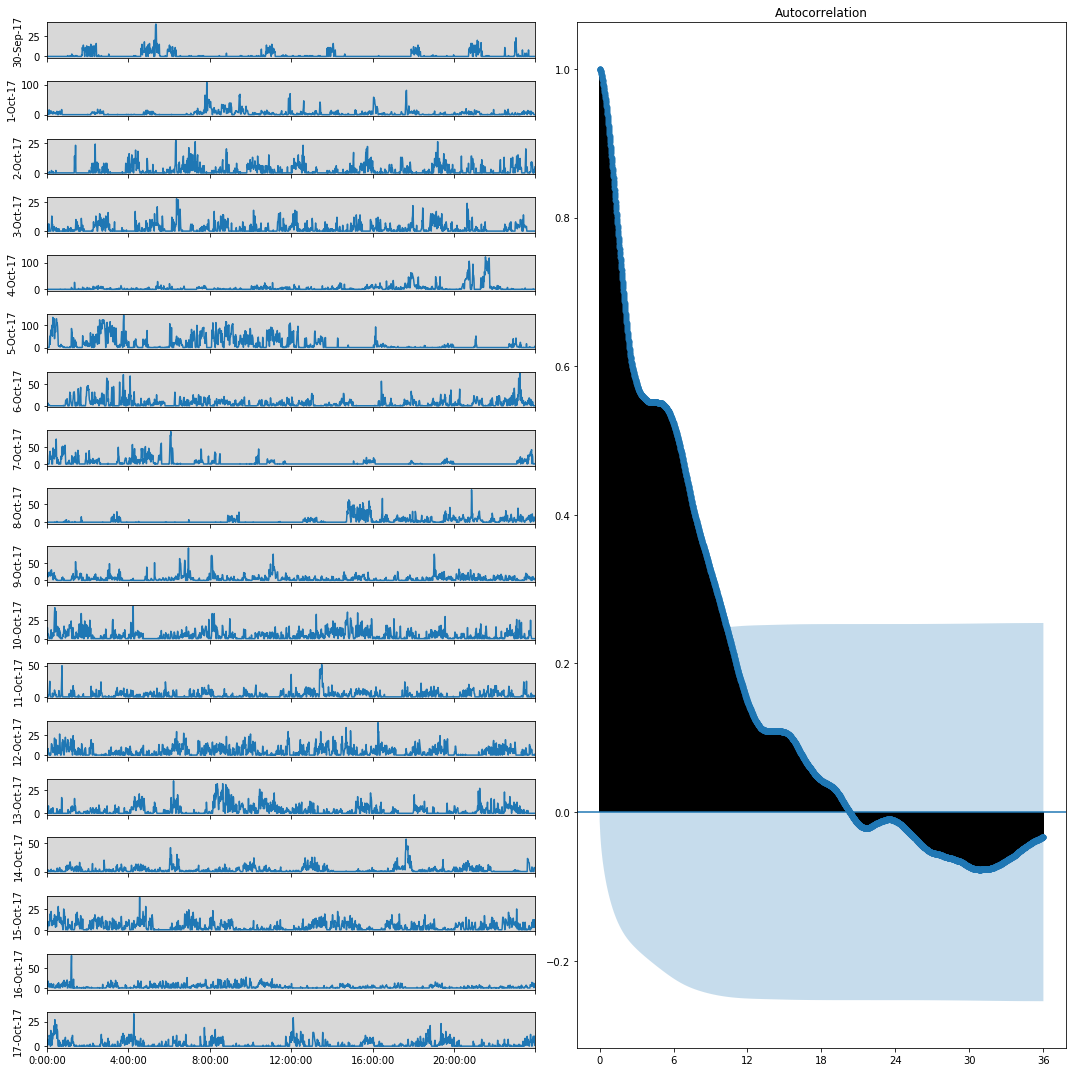

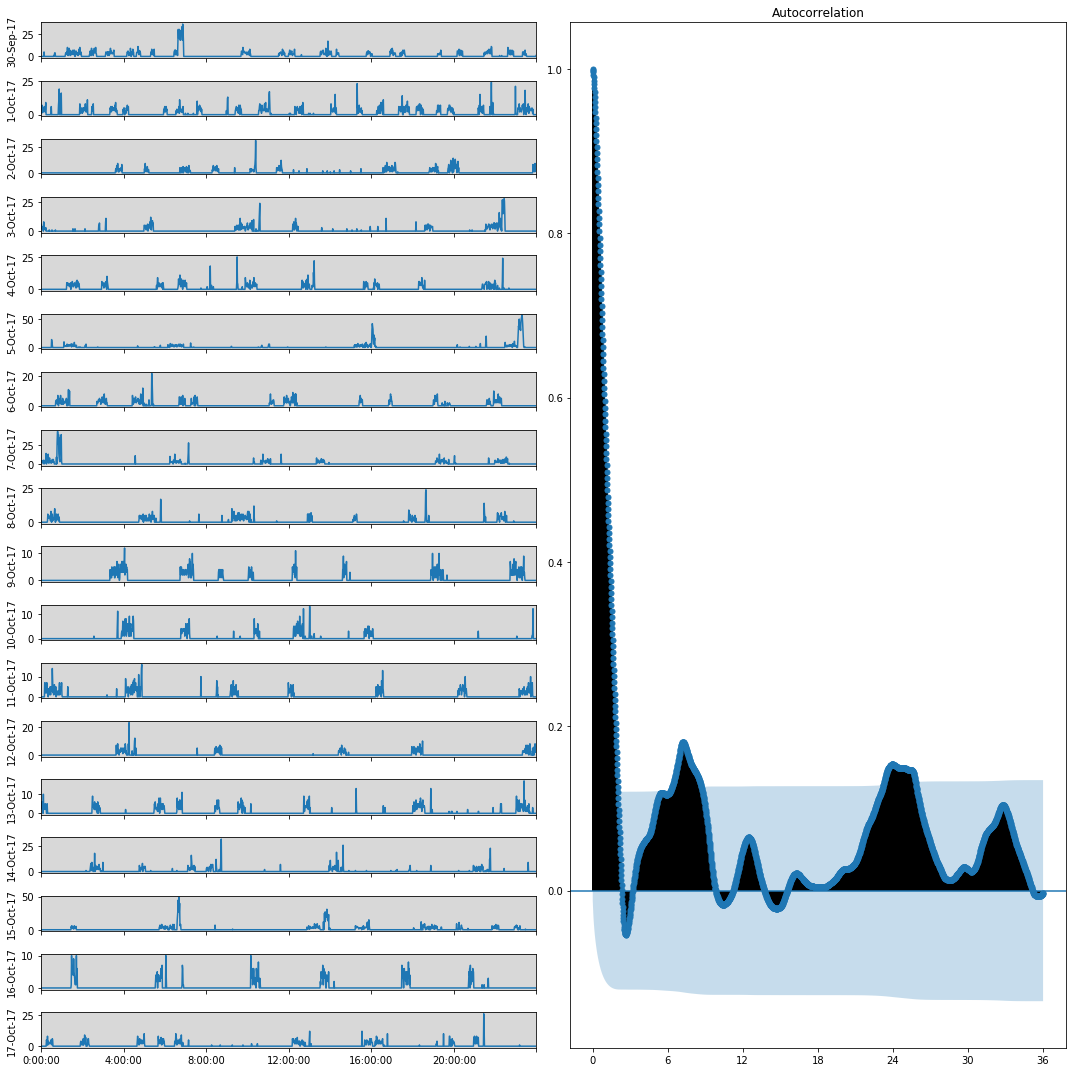

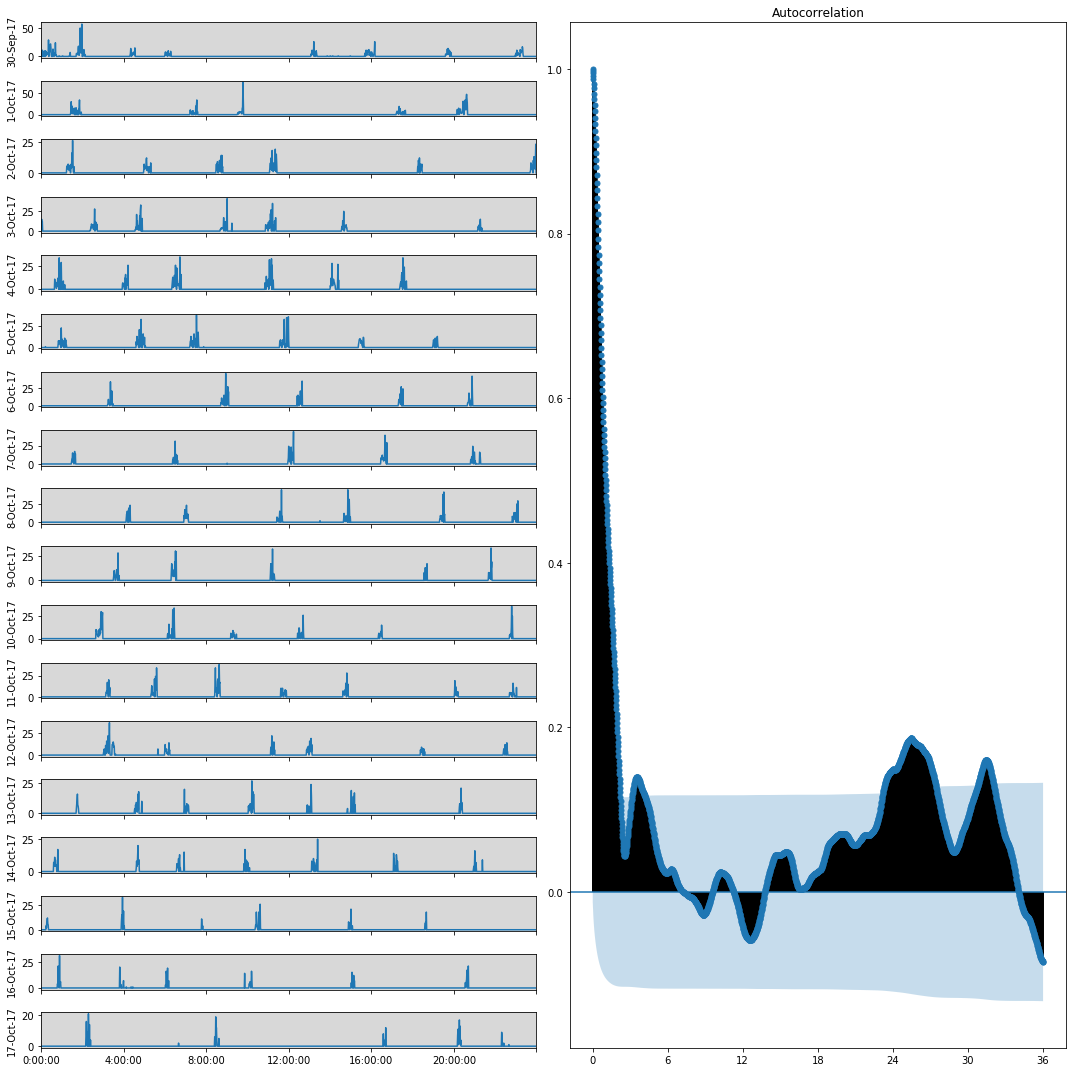

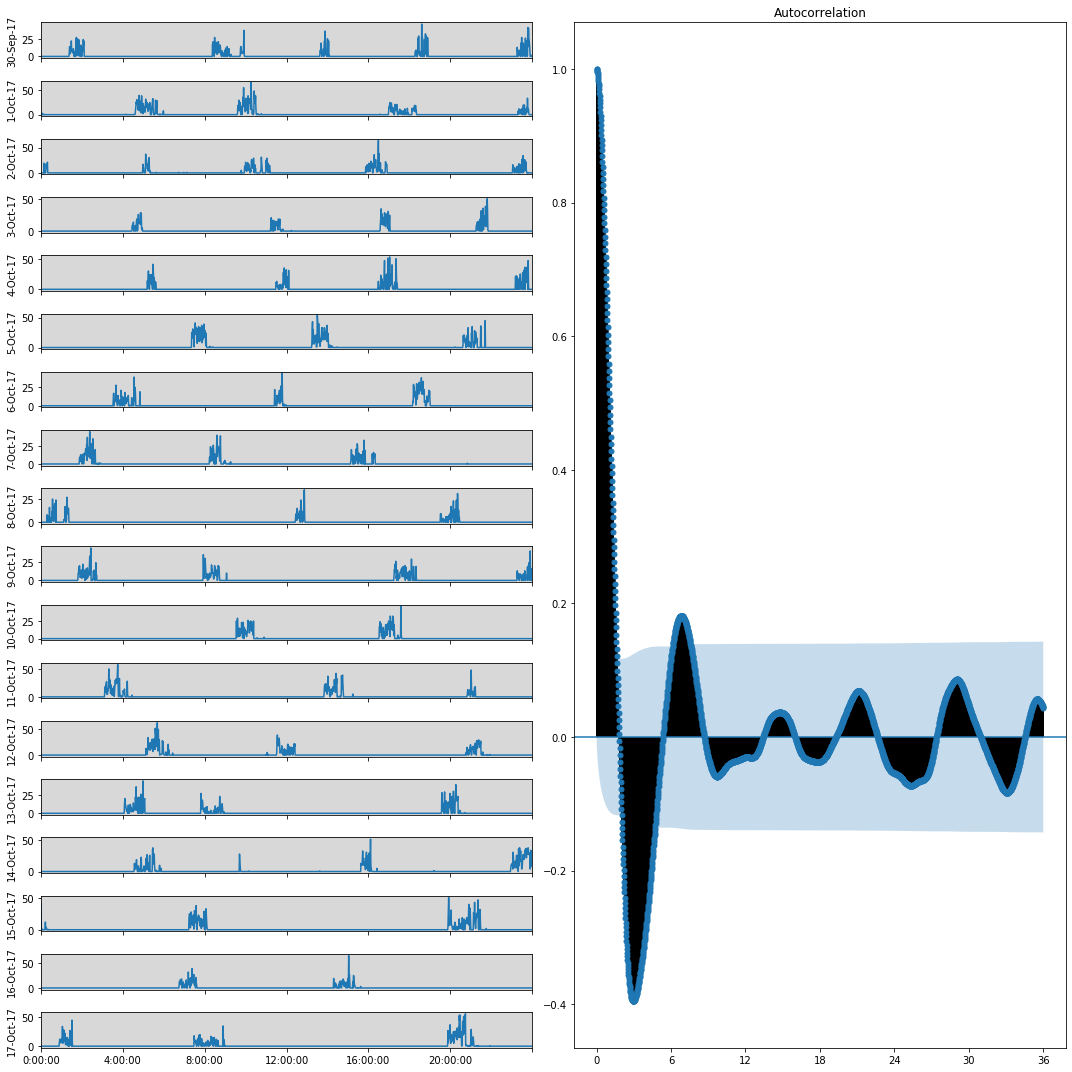

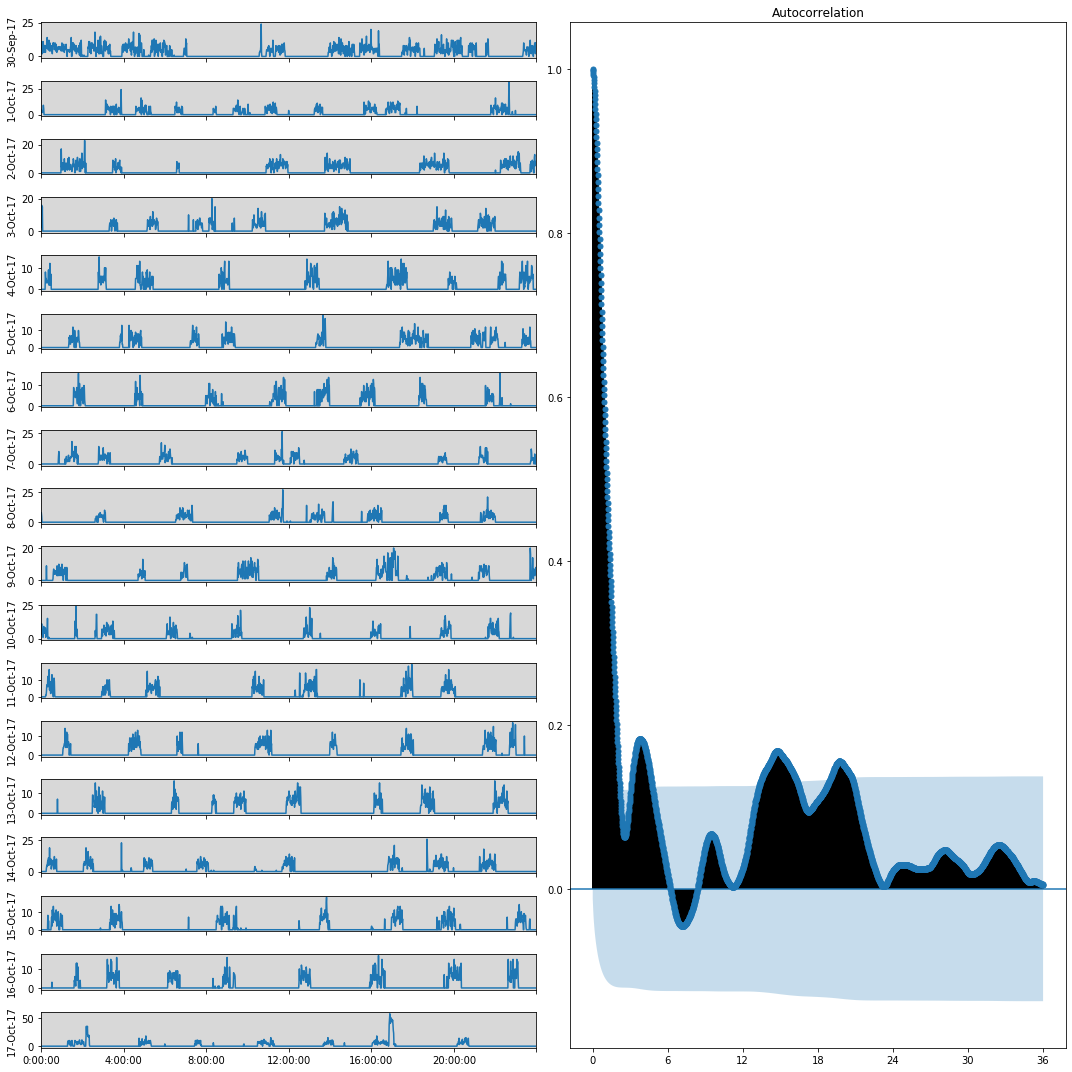

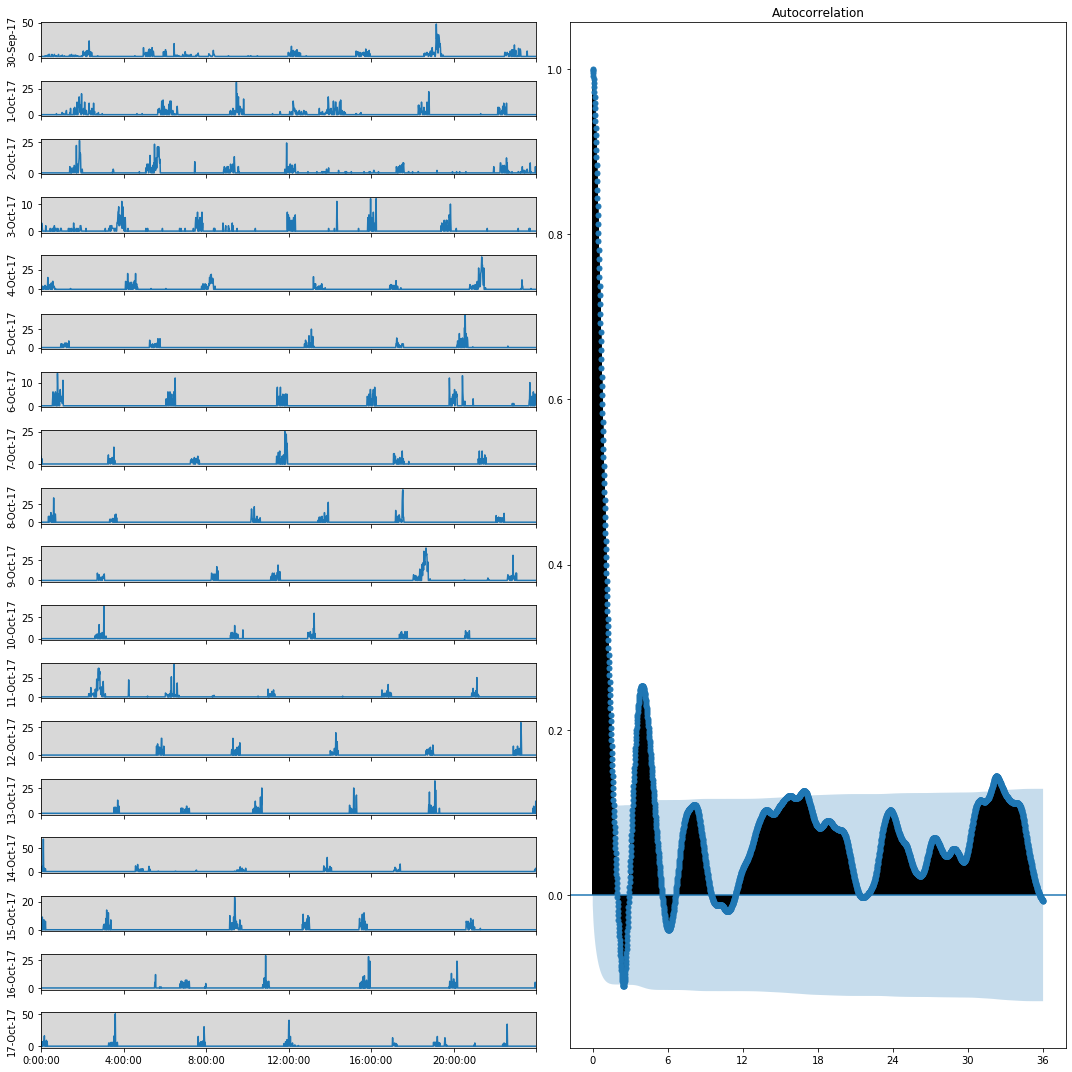

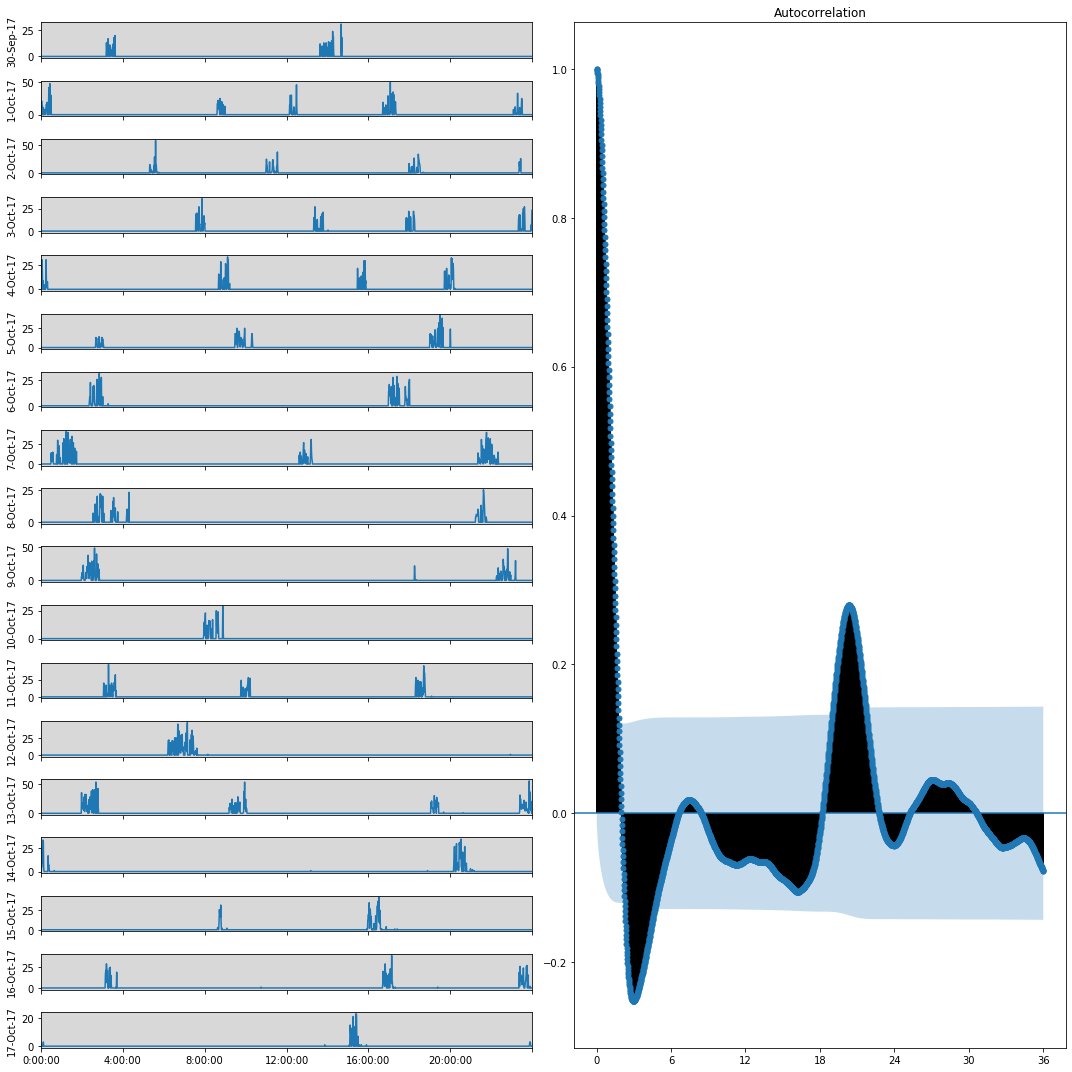

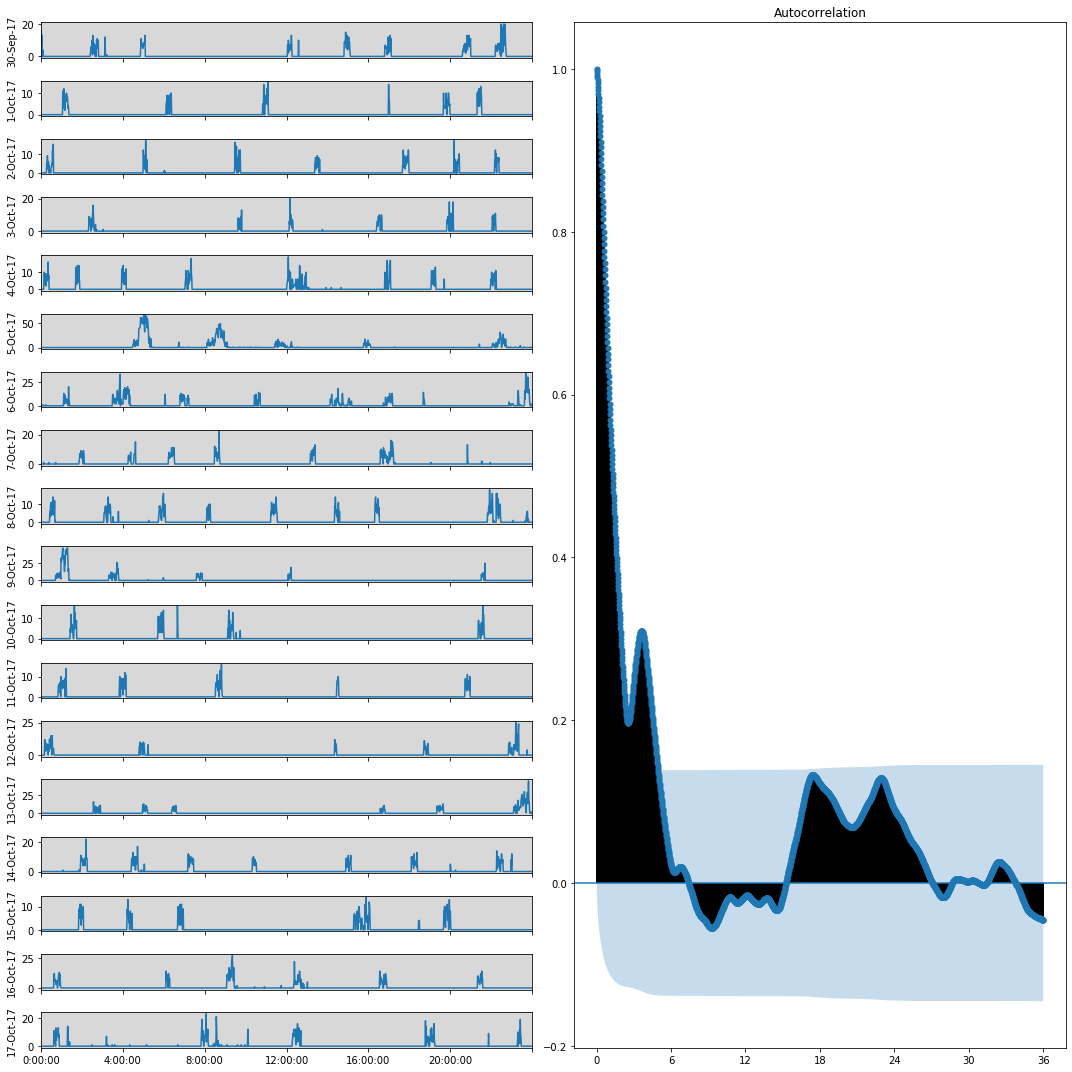

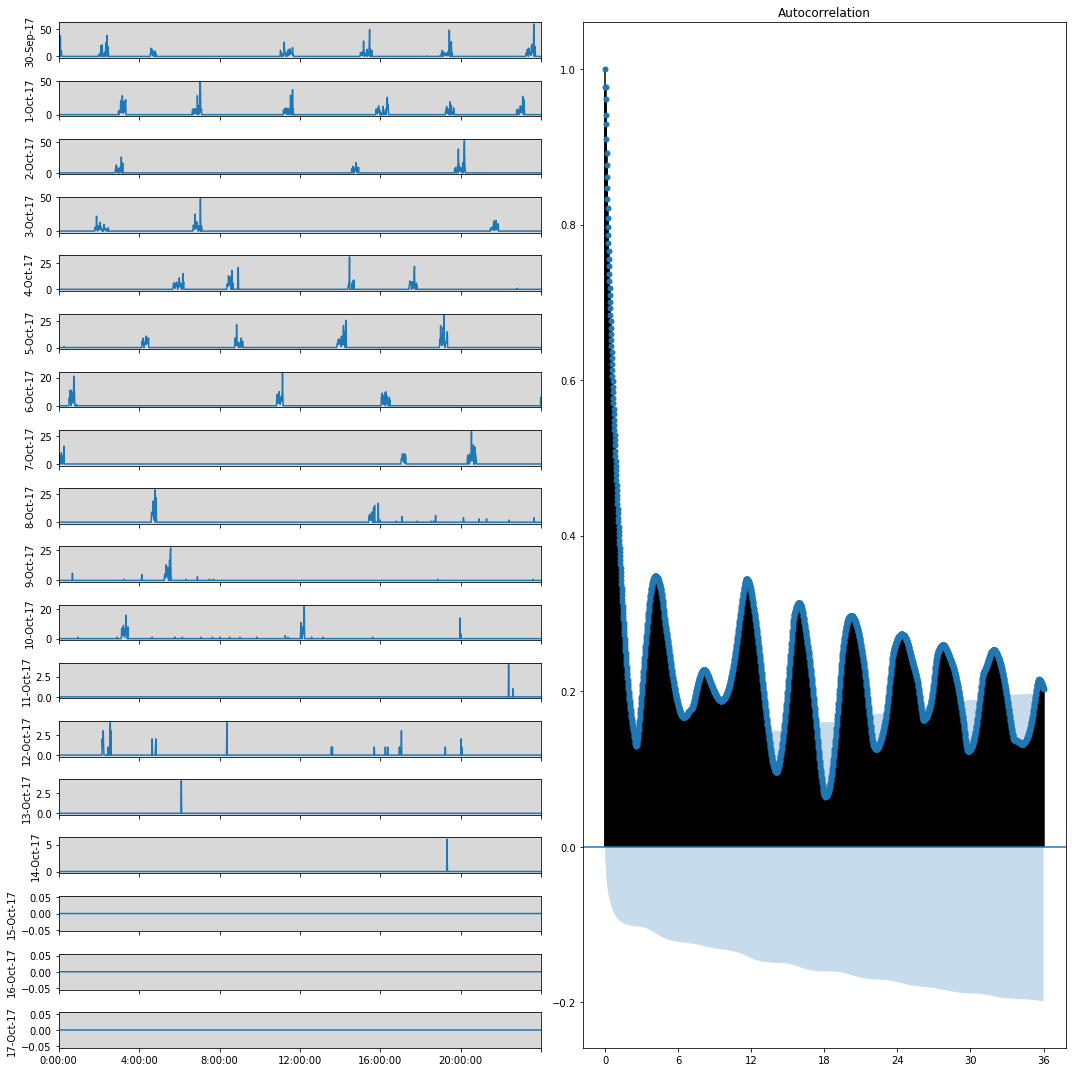

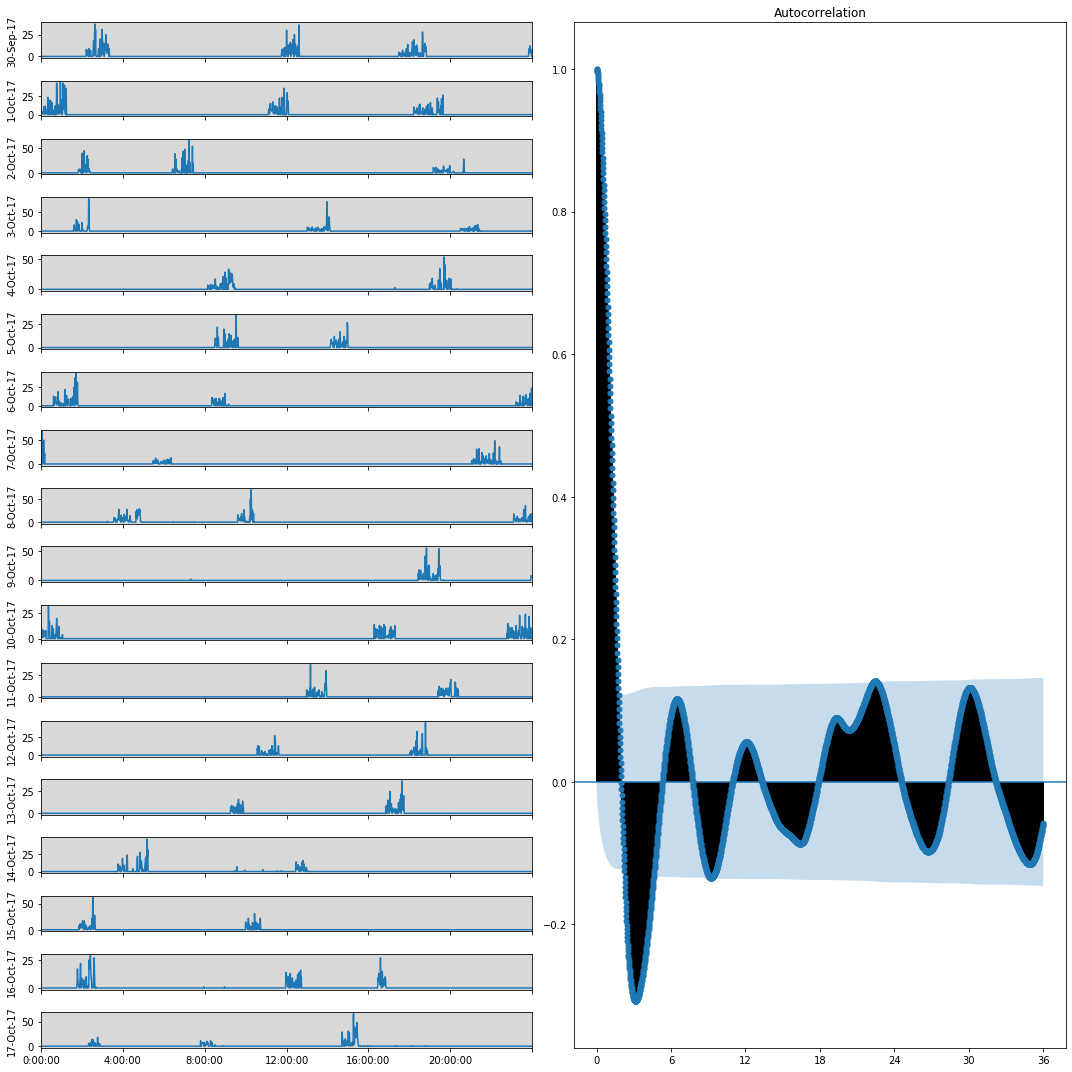

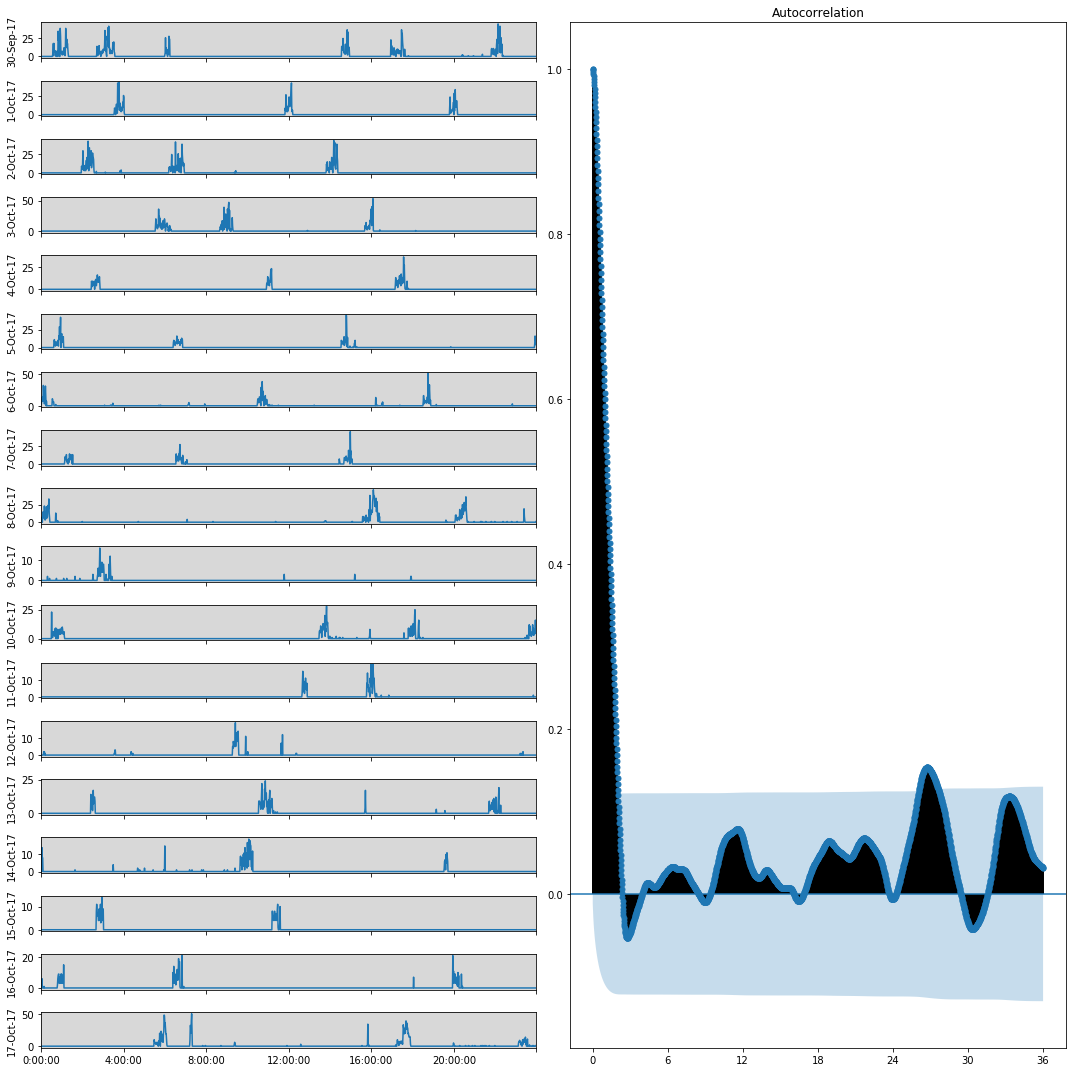

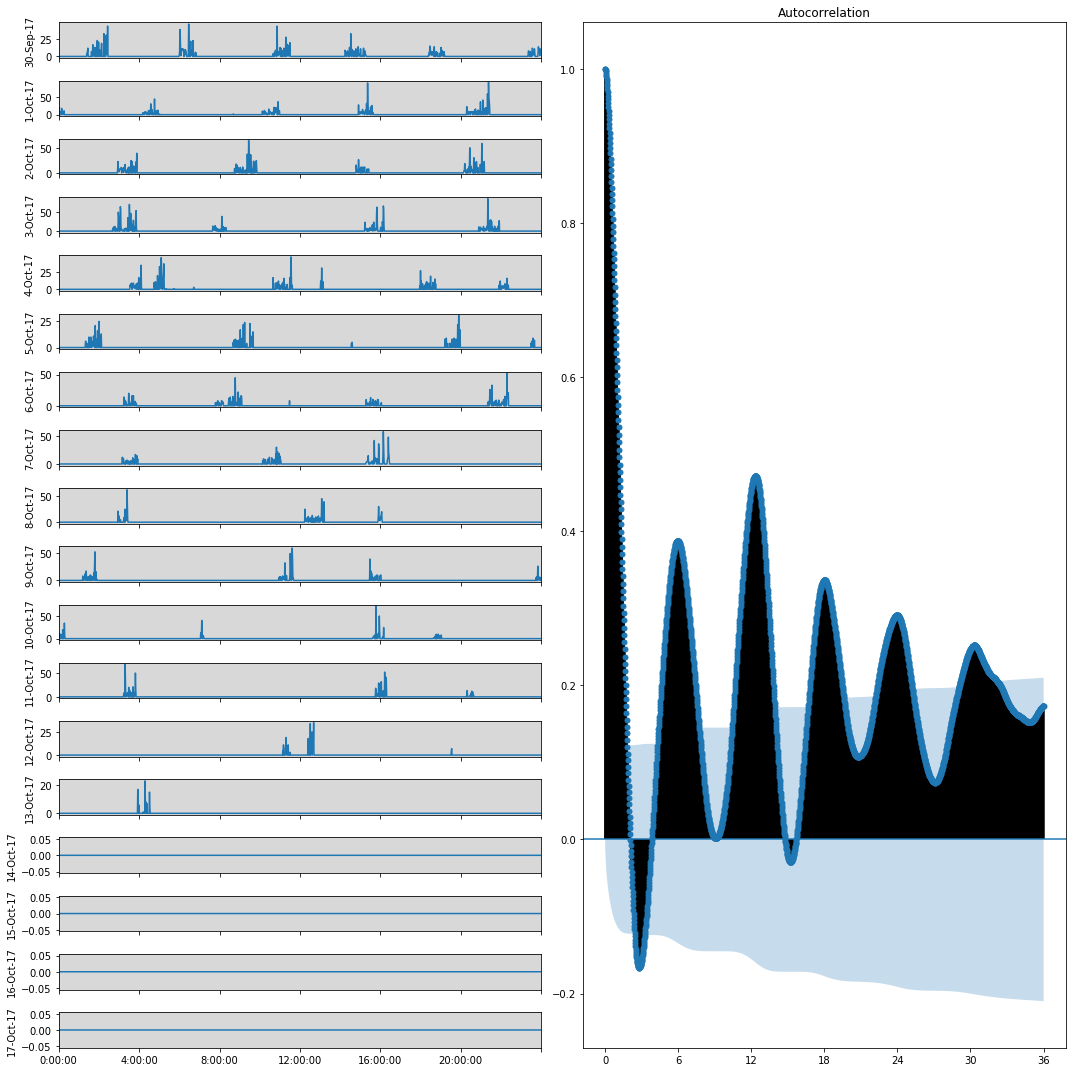

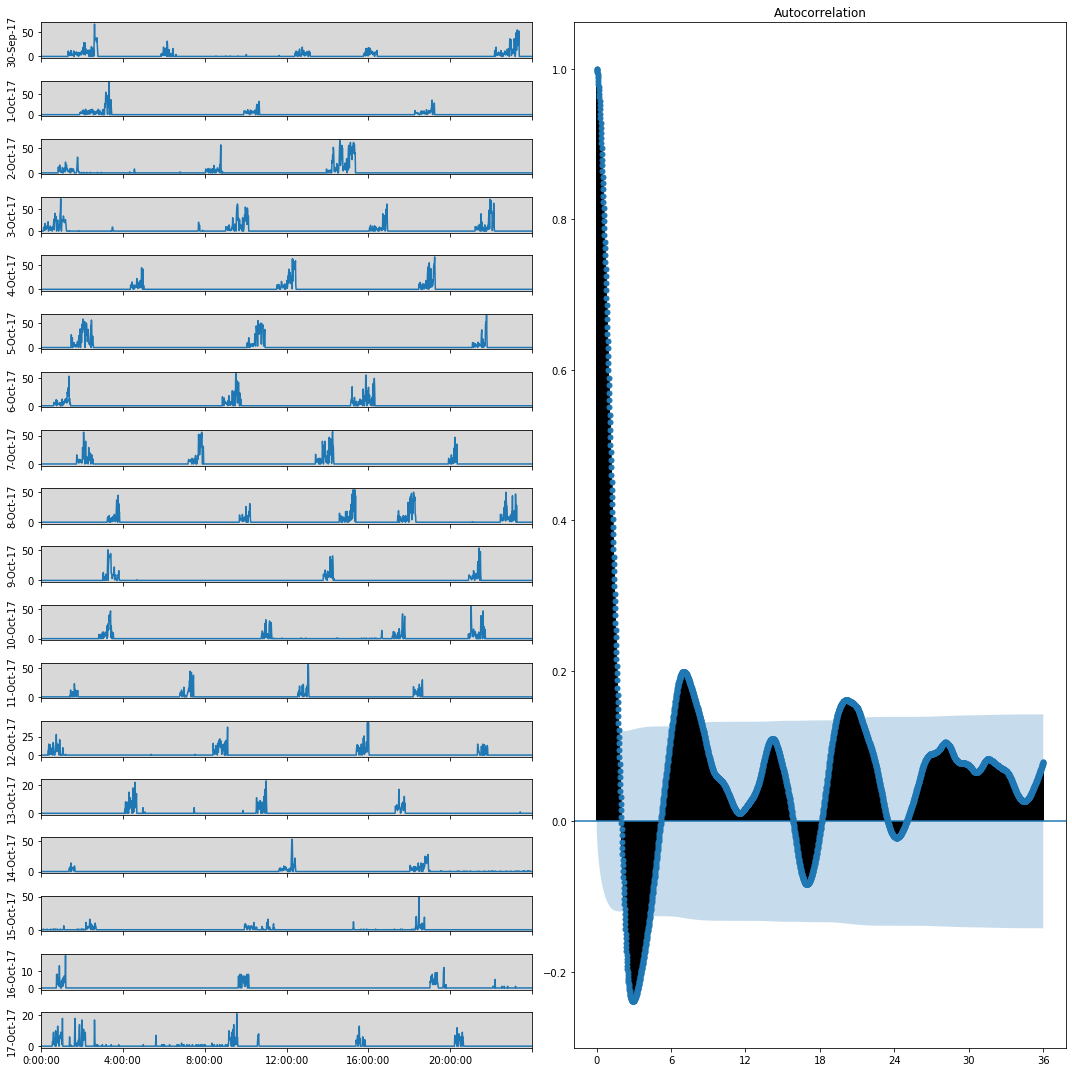

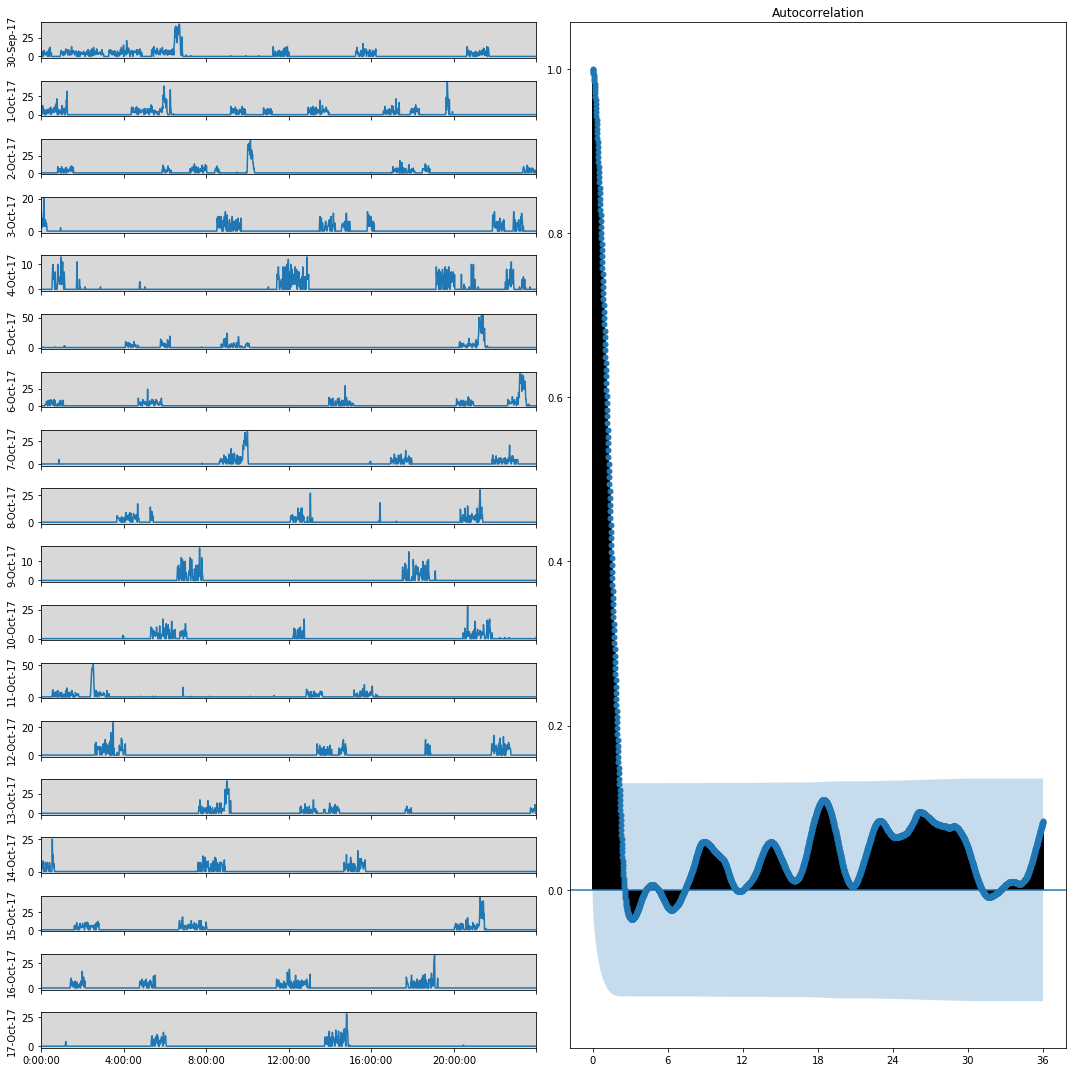

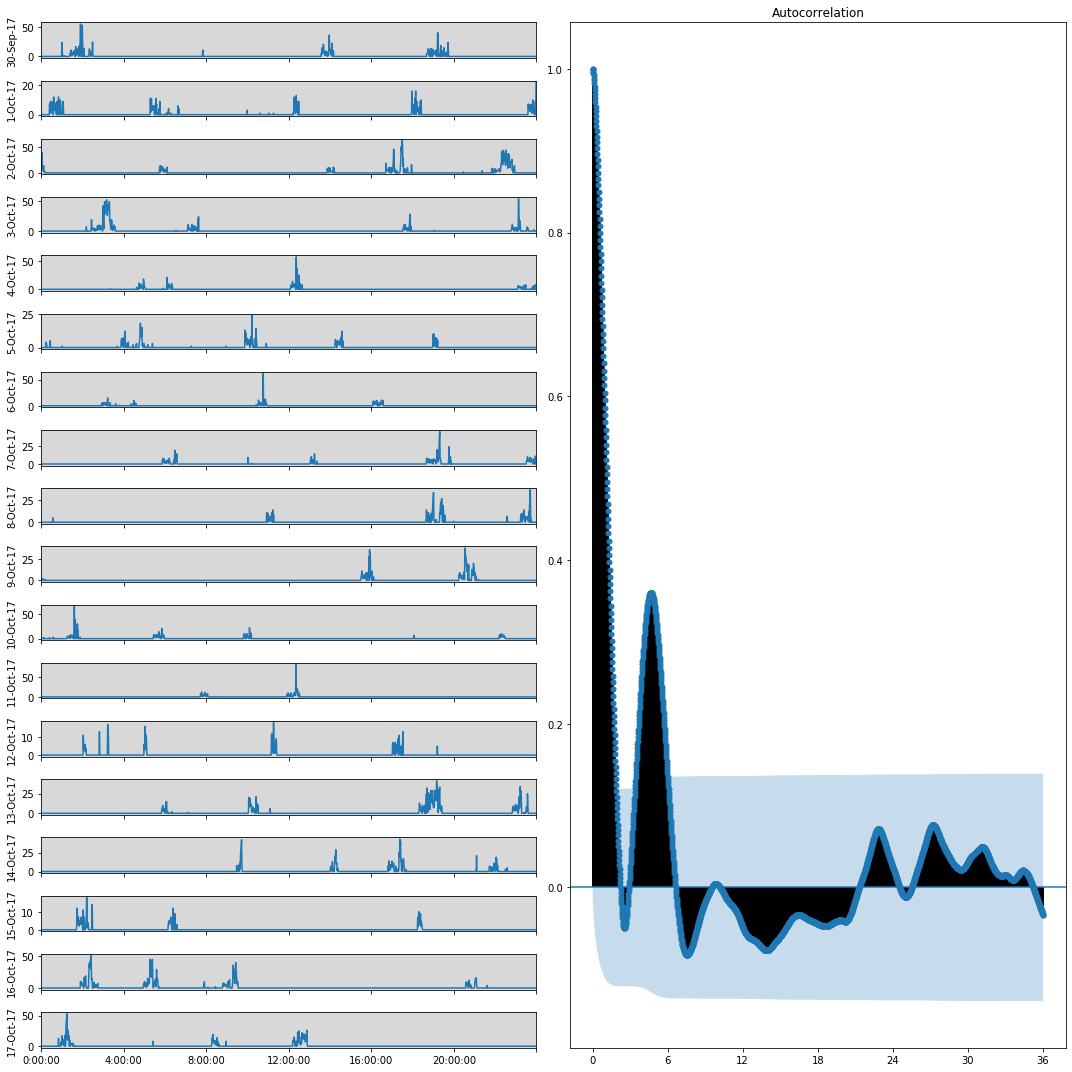

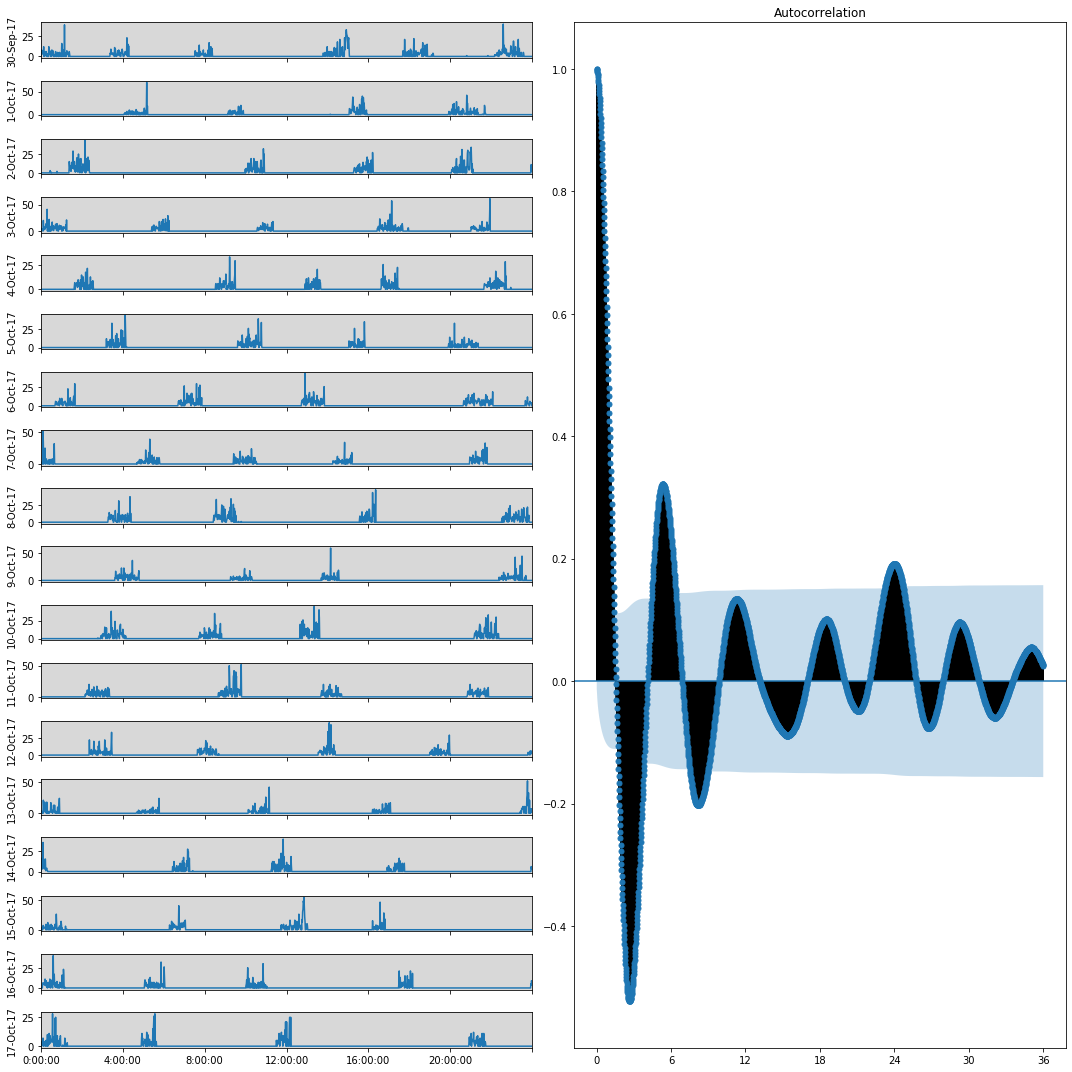

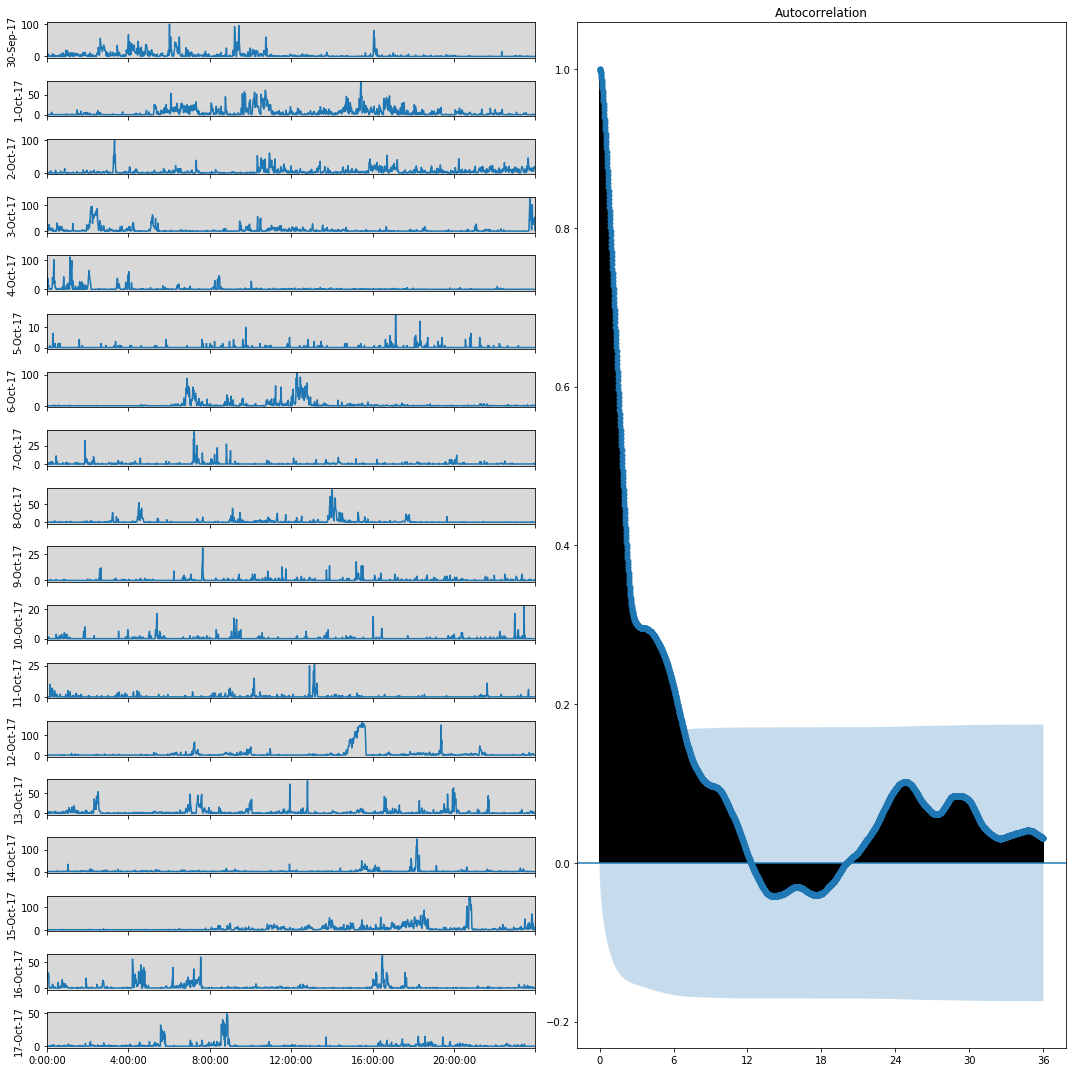

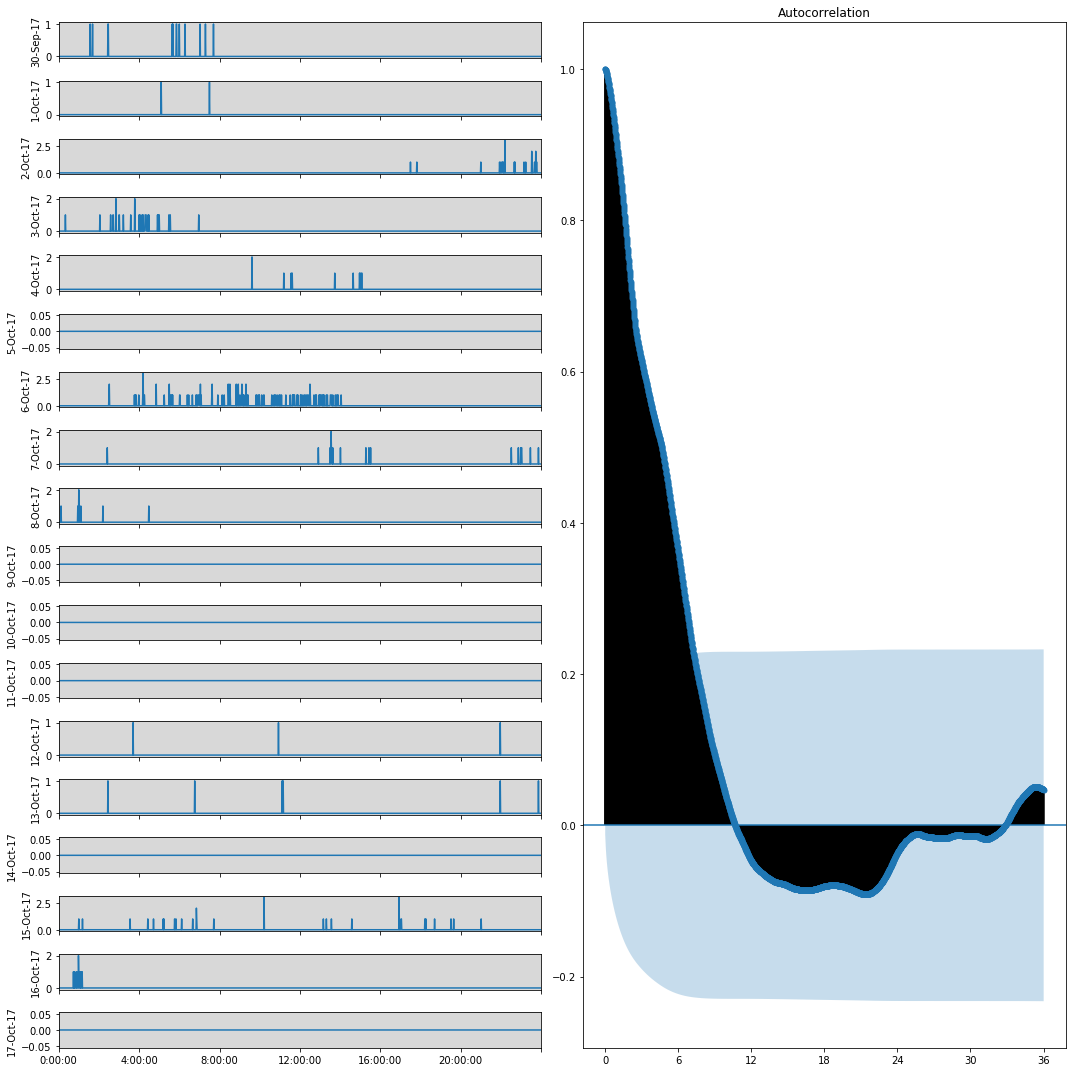

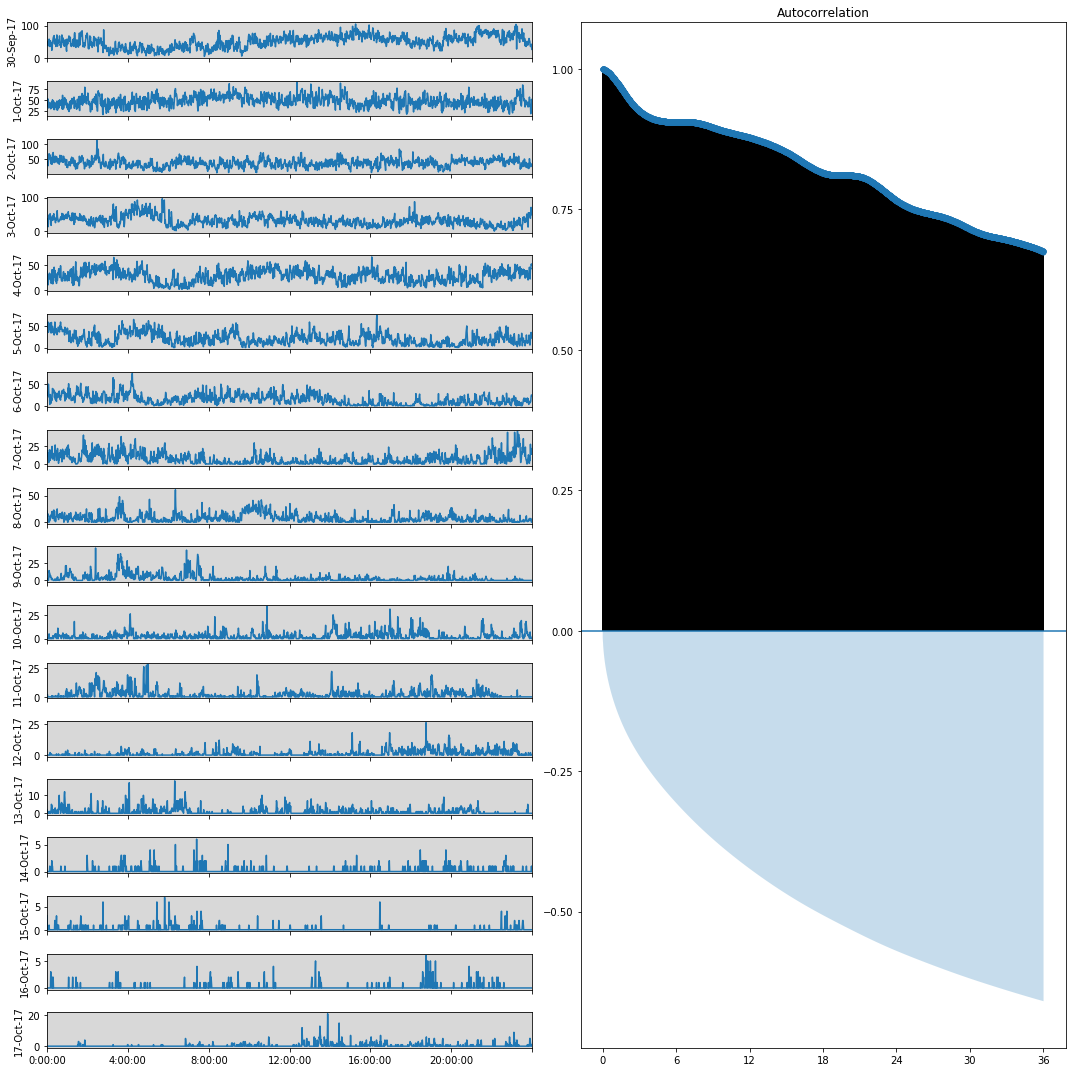

In [27]:
#Run through the list of spiders and make raster and ACF images for each spider 
for i in range(0,len(spider)):
    #LD_file_name='LD_Rasters_with_ACF/'+spider[i]+'_LD.png'
    #Plot_Raster_ACF(LD,spider[i],LD_Rolling.iloc[:,i+1],LD_file_name)
    DD_file_name='DD_Rasters_with_ACF/'+spider[i]+'_DD.png'
    Plot_Raster_ACF(DD,spider[i],DD_Rolling.iloc[:,i+1],DD_file_name)

## Generate a .csv file to record the rhythm of each spider

In [24]:
#Create a .csc file to record the result of each spider's rhythm after visual inspection
headers=['LD','DD']
Inspection=pd.DataFrame(columns=headers,index=spider)
Inspection.to_csv("Rhythm.csv") 